In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline


In [13]:
import sys
sys.path.append('/home/courtney/voxelmorph/src')
import os
import glob
import sys
import random
from argparse import ArgumentParser
import time

# third-party imports
import tensorflow as tf
import numpy as np
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam
from keras.models import load_model, Model
from keras.losses import mean_squared_error
import keras.backend as K
from neuron.plot import slices
import scipy.io as sio
from scipy.interpolate import interpn
import matplotlib.pyplot as plt
import nibabel as nib
from pynd.segutils import seg_overlay, seg_overlap


# project imports
sys.path.append('../ext/medipy-lib')
import medipy
import networks
from medipy.metrics import dice
import datagenerators
import losses
from restrict import restrict_GPU_tf, restrict_GPU_keras

In [4]:
def restrict_GPU_tf(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        tf.Session(config=config)
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [5]:
# Keras 
def restrict_GPU_keras(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        set_session(tf.Session(config=config))
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [26]:
def visualize(model_name, iter_num, gpu_id, n_test, region_number=1, max_clip=0.7):    
    test_brain_file = open('../src/val_files.txt')
    test_brain_strings = test_brain_file.readlines()
    test_brain_strings = [x.strip() for x in test_brain_strings]
    n_batches = len(test_brain_strings)
    good_labels = sio.loadmat('../data/labels.mat')['labels'][0]
    
    # setup
    gpu = '/gpu:' + str(gpu_id)
    #     print(gpu)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

    restrict_GPU_tf(str(gpu_id))
    restrict_GPU_keras(str(gpu_id))

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    set_session(tf.Session(config=config))

    vol_size=(160,192,224)
    nf_enc=[16,32,32,32]
    nf_dec=[32,32,32,32,32,16,16]
    
    atlas_vol = nib.load('../t2_atlas_027_S_2219.nii').get_data()[np.newaxis,...,np.newaxis]
    atlas_seg = nib.load('../t2_atlas_seg_027_S_2219.nii').get_data()
    
    atlas_vol = atlas_vol/np.max(atlas_vol) * max_clip

    images = []
    for step in range(0, n_test):
        vol_name, seg_name = test_brain_strings[step].split(",")
        X_vol, X_seg = datagenerators.load_example_by_name(vol_name, seg_name)
        images.append([X_vol, X_seg])

    sz = atlas_seg.shape
    z_inp1 = tf.placeholder(tf.float32, sz)
    z_inp2 = tf.placeholder(tf.float32, sz)
    z_out = losses.kdice(z_inp1, z_inp2, good_labels)
    kdice_fn = K.function([z_inp1, z_inp2], [z_out])

    nn_trf_model = networks.nn_trf(vol_size)

    start_time = time.time()

    # load weights of model
    with tf.device(gpu):
        net = networks.unet(vol_size, nf_enc, nf_dec)
        net.load_weights('../models/' + model_name +
                         '/' + str(iter_num) + '.h5')

    print('model loaded', time.time()-start_time)
    dice_means = []

    for step in range(0, n_test):
        X_vol, X_seg = images[step]

        with tf.device(gpu):
            pred = net.predict([X_vol, atlas_vol])
            warp_seg = nn_trf_model.predict([X_seg, pred[1]])
            dices = kdice_fn([warp_seg[0,:,:,:,0], atlas_seg])
            visualize_seg(np.squeeze(atlas_vol), np.squeeze(warp_seg), region_number=region_number)
            visualize_seg(np.squeeze(atlas_vol), np.squeeze(atlas_seg), region_number=region_number)

    print('tested patients', time.time()-start_time)
    print('dice mean', np.mean(dices))
    print('dice std', np.std(dices))
    return dices

In [25]:
def visualize_seg(vol, seg, region_number=1):
    normalized_vol = vol/np.max(vol)
    seg_one_region = np.copy(seg)
    seg_one_region[seg_one_region!=region_number] = 0
    seg_one_region[seg_one_region==region_number] = 1
    img = seg_overlay(normalized_vol, seg_one_region.astype(np.int))
    plt.figure(figsize=(20,10))
    slices([img[80, :, :, :], img[:, 90, :, :], img[:, :, 100, :]])

Using GPU:1 with 0% of the memory
Using GPU:1 with 0% of the memory
model loaded 1.1864914894104004


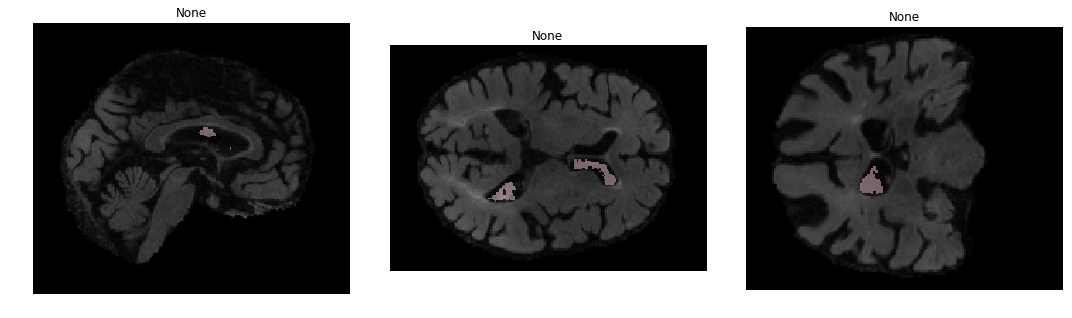

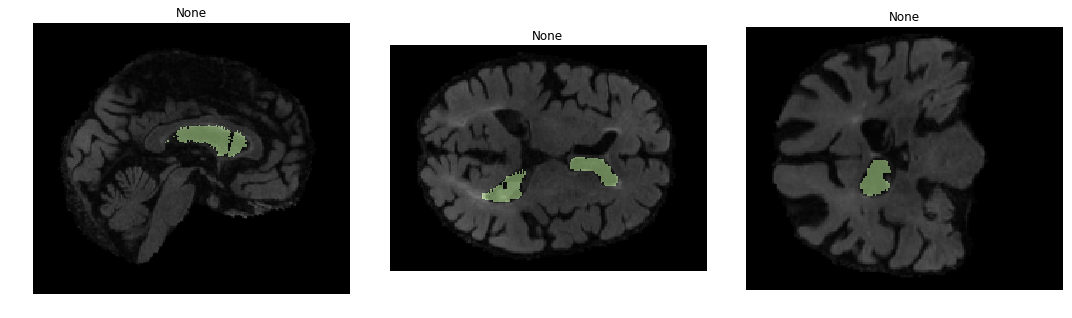

tested patients 11.968639850616455
dice mean 0.6033768
dice std 0.14844348


In [27]:
dices = visualize('mi_t2_b48l8', 16000, 1, 1, region_number=4, max_clip=0.7)